In [781]:
from PIL import Image
import numpy as np
import glob
import pylab as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix 
from matplotlib.colors import ListedColormap 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn import metrics
from sklearn.svm import SVC
import skimage
from skimage import filters
from skimage import measure
import imutils
from imutils import perspective
from imutils import contours
from skimage.measure import find_contours
import scipy
import scipy.misc
import scipy.cluster
import binascii
import struct

import warnings
warnings.filterwarnings("ignore")
import cv2


In [2]:
folders = glob.glob('/Users/ayyoki/Desktop/untitled/542/malignant')
imagenames_list = []
for folder in folders:
    for f in glob.glob(folder+'/*.jpg'):
        imagenames_list.append(f)

read_images = []        

for image in imagenames_list:
    read_images.append(Image.open(image))

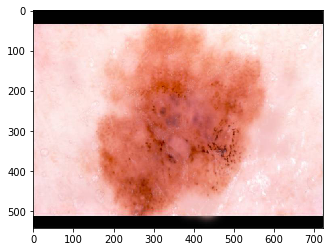

In [3]:
plt.imshow(read_images[3])

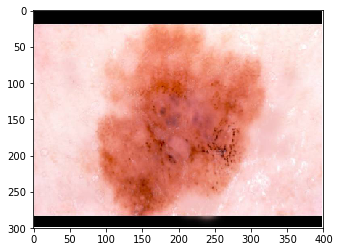

In [4]:
# Resize the images to 300*400 to make sure features are having the same dimension
(width, height) = (400, 300)
img_resized = [x.resize((width, height)) for x in read_images];
plt.imshow(img_resized[3])

In [5]:
pixels = [img.getdata() for img in img_resized]

In [6]:
len(pixels)

150

In [7]:
pix_vals = []
for i in range(0,150):
    pix_vals.append(list(pixels[i]))

In [8]:
pix_vals_flat = []
for i in range(0,150):
    pix_vals_flat.append([x for sets in pix_vals[i] for x in sets])

In [9]:
len(pix_vals_flat)

150

In [10]:
# Constructing features matrix for malignant mole (y = 1)
df = pd.DataFrame.from_records(pix_vals_flat)

In [11]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,359990,359991,359992,359993,359994,359995,359996,359997,359998,359999
0,31,29,30,11,9,10,1,0,0,1,...,1,1,1,1,0,0,0,3,3,3
1,138,104,128,140,111,133,145,116,138,144,...,174,172,141,173,174,139,179,175,141,178
2,153,126,119,162,126,114,157,127,116,165,...,158,196,163,158,195,155,153,187,151,151
3,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,226,208,196,228,206,195,224,194,183,224,...,207,237,212,207,237,212,207,236,224,224


In [12]:
# Adding one column y to indicate whether a observation is 'benigh' group or 'malignant' group
# This is for maligant group (y = 1)
df['y'] = 1

In [13]:
paths = glob.glob('/Users/ayyoki/Desktop/untitled/542/benign')
imagenames_list_benigh = []
for path in paths:
    for f in glob.glob(path+'/*.jpg'):
        imagenames_list_benigh.append(f)

read_images_benigh = []        

for image in imagenames_list_benigh:
    read_images_benigh.append(Image.open(image))

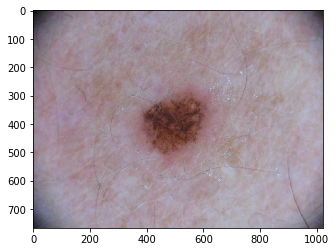

In [14]:
plt.imshow(read_images_benigh[3])

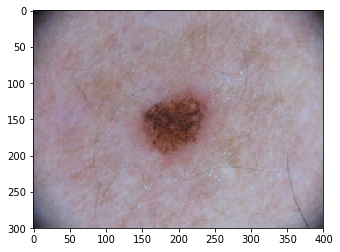

In [15]:
# Resize the images to 300*400 to make sure features are having the same dimension
(width, height) = (400, 300)
img_resized_benigh = [x.resize((width, height)) for x in read_images_benigh];
plt.imshow(img_resized_benigh[3])

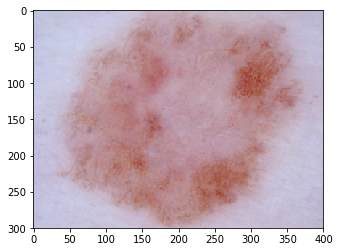

In [894]:
plt.imshow(img_resized_benigh[51])

In [17]:
pixels_benigh = [img.getdata() for img in img_resized_benigh]

In [18]:
pix_vals_benigh = []
for i in range(0,150):
    pix_vals_benigh.append(list(pixels_benigh[i]))

In [19]:
pix_vals_flat_benigh = []
for i in range(0,150):
    pix_vals_flat_benigh.append([x for sets in pix_vals_benigh[i] for x in sets])

In [20]:
# Constructing features matrix for benigh group (y = 0)
df_benigh = pd.DataFrame.from_records(pix_vals_flat_benigh)

In [21]:
df_benigh.head()

,0,1,2,3,4,5,6,7,8,9,...,359990,359991,359992,359993,359994,359995,359996,359997,359998,359999
0,175,183,194,160,182,205,154,187,218,155,...,235,195,224,240,192,224,245,201,217,230
1,223,222,228,227,226,232,220,219,225,221,...,224,219,220,225,218,219,224,229,230,235
2,44,44,44,2,2,2,12,12,12,4,...,16,13,15,14,1,1,0,24,25,20
3,42,42,44,9,9,11,24,24,26,19,...,70,62,59,70,55,53,58,73,71,72
4,37,37,37,8,4,5,3,0,0,0,...,0,1,0,0,0,0,0,3,4,6


In [22]:
# Adding one column y to indicate whether a observation is 'benigh' group or 'malignant' group
# This is for benigh group (y = 0)
df_benigh['y'] = 0

In [23]:
frames = [df, df_benigh]
dataset = pd.concat(frames)

In [24]:
dataset.shape

(300, 360001)

In [25]:
#By observing the images, we can see that only the range 130 (117000) to 250 (225000) on x-axis contains the information of disease, so we can remove
#colums that contain background.

In [961]:
new_df_x = dataset.drop('y', axis = 1)
new_df_x = new_df_x.iloc[:, 117000:225000]
new_df_y = dataset['y']
new_df_x.shape

(300, 108000)

## Random Forest Classification

In [962]:
#train-test split
x_train, x_test, y_train, y_test = train_test_split(new_df_x, new_df_y, test_size = 0.3, random_state = 0)

In [963]:
#Standardlize
sc = StandardScaler()

In [964]:
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [965]:
clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=542, verbose=0,
            warm_start=False)
clf.fit(x_train,y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=542, verbose=0, warm_start=False)

In [966]:
y_pred=clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.7222222222222222


In [32]:
confusion_matrix(y_test, y_pred)

array([[37, 11],
       [14, 28]])

[Text(0, 0.5, 'malignant'), Text(0, 1.5, 'benign')]

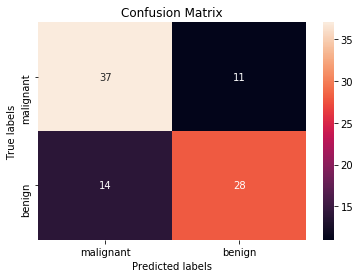

In [33]:
cm =confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['malignant', 'benign']); ax.yaxis.set_ticklabels(['malignant', 'benign'])

## Logistic Regression

In [34]:
log_mod = LogisticRegression()
log_mod.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [35]:
y_pred = log_mod.predict(x_test)
print('Accuracy of logistic regression on test set:{:.2f}'.format(log_mod.score(x_test, y_test)))

Accuracy of logistic regression on test set:0.66


[[37 11]
 [20 22]]


[Text(0, 0.5, 'malignant'), Text(0, 1.5, 'benign')]

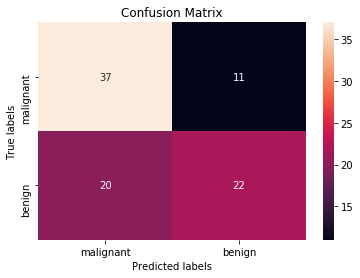

In [36]:
print(confusion_matrix(y_test, y_pred))
cm =confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['malignant', 'benign']); ax.yaxis.set_ticklabels(['malignant', 'benign'])

## Kernel SVM

In [37]:
# Fitting Kernel SVM to the Training set
Kernel_classifier = SVC(kernel = 'rbf', random_state = 0)
Kernel_classifier.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.001, verbose=False)

In [38]:
y_pred_kernel = Kernel_classifier.predict(x_test)
print("Accuracy kernel SVM:",metrics.accuracy_score(y_test, y_pred_kernel))


Accuracy kernel SVM: 0.7333333333333333


[[40  8]
 [16 26]]


[Text(0, 0.5, 'malignant'), Text(0, 1.5, 'benign')]

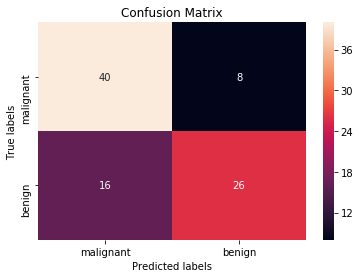

In [39]:
print(confusion_matrix(y_test, y_pred_kernel))
cm =confusion_matrix(y_test, y_pred_kernel)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['malignant', 'benign']); ax.yaxis.set_ticklabels(['malignant', 'benign'])

## Question 2

In [63]:
import skimage
from skimage import filters

In [611]:
###convert the image data back tp numpy arrary, with the same resize picture
###we had in question 1
###numpy array needed for further analysis - area, etc. 
image_good_resize = []

for i in range(0,150):
    n = np.array(img_resized_benigh[i])
    image_good_resize.append(n)

In [612]:
image_bad_resize = []

for i in range(0,150):
    n = np.array(img_resized[i])
    image_bad_resize.append(n)

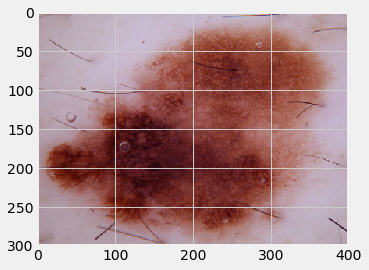

In [1078]:
plt.imshow(image_bad_resize[96])

In [1081]:
img = image_bad_resize[96]
temp = img.copy()
val = filters.threshold_otsu(temp)
mask = temp < val
    #apply the fliter to background
for i in range(mask.shape[2]):
    for j in range(temp.shape[2]):
        temp[:,:,j] = temp[:,:,j] * mask[:,:,i]

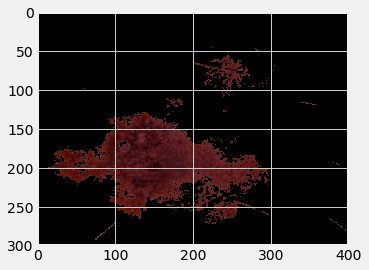

In [1083]:
plt.imshow(temp)

## Add new feature: areas and primeters of contours to replace pixel

In [619]:
def get_area_primeter(image):
    img = image.copy()
    ##get the mask of the backgroud
    val = filters.threshold_otsu(img)
    mask = pic < val
    #apply the fliter to background
    temp = img
    for i in range(mask.shape[2]):
        for j in range(temp.shape[2]):
            temp[:,:,j] = temp[:,:,j] * mask[:,:,i]
    ##extract Contours from the flitered graph
    pp = temp 
    gray = cv2.cvtColor(pp, cv2.COLOR_BGR2GRAY)
    edged = cv2.Canny(gray, 50, 100)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    ###find Contours existing in the graph
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    ###get the area and primeter
    areas = []

    for c in cnts:
        for c in cnts:
            areas.append(cv2.contourArea(c))
    perimeter = []
    for c in cnts:
        for c in cnts:
            perimeter.append(cv2.arcLength(c,True))
    return([max(areas),max(perimeter)])        
    

In [639]:
##area, primeter of good 
areas_malignant = [None] * 150

primeter_malignant = [None] * 150


for i in range(0,150):
    p = get_area_primeter(image_bad_resize[i])
    areas_malignant[i] = p[0]
    primeter_malignant[i] = p[1]
    

In [640]:
areas_benign = [None] * 150
primeter_benign = [None] * 150
for i in range(0,150):
    p = get_area_primeter(image_good_resize[i])
    areas_benign[i] = p[0]
    primeter_benign[i] = p[1]

In [656]:
malignant_data = pd.DataFrame(areas_malignant,columns =['area'])
malignant_data['primeter'] = primeter_malignant
malignant_data['y'] = 1
malignant_data.head()

,area,primeter,y
0,18081.5,1999.408284,1
1,11866.0,2272.302726,1
2,25266.5,1442.589962,1
3,23479.5,4706.328321,1
4,17896.5,2011.207273,1


In [657]:
benign_data = pd.DataFrame(areas_benign,columns =['area'])
benign_data['primeter'] = primeter_benign
benign_data['y'] = 0
benign_data.head()

,area,primeter,y
0,37126.0,2107.449914,0
1,45742.0,1827.224518,0
2,21889.0,1494.004176,0
3,23660.0,1581.460019,0
4,24501.0,1451.661030,0


In [659]:
q2_data = pd.concat([malignant_data,benign_data])

In [662]:
q2_data.head()

,area,primeter,y
0,18081.5,1999.408284,1
1,11866.0,2272.302726,1
2,25266.5,1442.589962,1
3,23479.5,4706.328321,1
4,17896.5,2011.207273,1


## Add more feature 2: most representative region's color (red,green,blue)

### Improve the pixel collection and and area and primeter to the data

In [895]:
top_benign = []

for i in range(0,150):
    n = np.array(img_resized_benigh[i])
    NUM_CLUSTERS = 5
    shape  = n.shape
    n = n.reshape(scipy.product(shape[:2]), shape[2]).astype(float)
    codes, dist = scipy.cluster.vq.kmeans(n, NUM_CLUSTERS)
    vecs, dist = scipy.cluster.vq.vq(n, codes)         
    counts, bins = scipy.histogram(vecs, len(codes))
    index_max = scipy.argmax(counts)  # find most frequent
    top_benign.append(codes[index_max])

In [897]:
top_malignant = []

for i in range(0,150):
    n = np.array(img_resized[i])
    val = filters.threshold_otsu(n)
    NUM_CLUSTERS = 5
    shape  = n.shape
    n = n.reshape(scipy.product(shape[:2]), shape[2]).astype(float)
    codes, dist = scipy.cluster.vq.kmeans(n, NUM_CLUSTERS)
    vecs, dist = scipy.cluster.vq.vq(n, codes)         
    counts, bins = scipy.histogram(vecs, len(codes))
    index_max = scipy.argmax(counts)  # find most frequent
    top_malignant.append(codes[index_max])

In [898]:
malignant_top_color = pd.DataFrame.from_records(top_malignant)

In [899]:
benign_top_color = pd.DataFrame.from_records(top_benign)

In [900]:
benign_top_color.head()

,0,1,2
0,173.146836,213.369128,251.390439
1,221.730844,222.099286,224.108785
2,141.745878,156.180742,176.435573
3,165.153745,149.861960,160.748571
4,185.420639,165.412548,168.307789


In [901]:
malignant_top_color.head()

,0,1,2
0,172.832753,164.188204,167.691979
1,185.506755,156.325870,189.918561
2,205.694997,169.638683,147.483760
3,251.825306,223.048839,221.862869
4,251.428407,205.384912,196.562317


In [902]:
malignant_top_color['y'] = 1

In [903]:
benign_top_color['y'] = 0

In [904]:
q2_data_part2 = pd.concat([malignant_top_color,benign_top_color])

In [915]:
q2_data.head()

,area,primeter,y,red,green,blue
0,18081.5,1999.408284,1,172.832753,164.188204,167.691979
1,11866.0,2272.302726,1,185.506755,156.325870,189.918561
2,25266.5,1442.589962,1,205.694997,169.638683,147.483760
3,23479.5,4706.328321,1,251.825306,223.048839,221.862869
4,17896.5,2011.207273,1,251.428407,205.384912,196.562317


In [907]:
q2_data['red'] = q2_data_part2[0]
q2_data['green'] = q2_data_part2[1]
q2_data['blue'] = q2_data_part2[2]

## Add more feature 3: image means and standard deviation

In [982]:
good = image_good_resize.copy()
bad = image_bad_resize.copy()

In [985]:
full=np.vstack((bad,good))
len(full)

300

In [1001]:
def get_mean_sv(image):
    img = image.copy()
    means, sd  = cv2.meanStdDev(img)
    return [means,sd]
    

In [1068]:
all_mean = [None] * 300
all_sd = [None] * 300
for i in range(0,300):
    p = get_mean_sv(full[i])
    all_mean[i] = p[0]
    all_sd[i] = p[1]

In [1069]:
mean= [[float(j) for j in i] for i in all_mean]
sd =  [[float(j) for j in i] for i in all_sd]

In [1070]:
mean_img = pd.DataFrame.from_records(mean)
sd_img = pd.DataFrame.from_records(sd)

In [1071]:
sd_img.head()

,0,1,2
0,23.790440,34.593967,44.359141
1,37.711111,36.641575,46.862885
2,29.625158,42.110558,46.346421
3,77.102197,74.961628,79.304857
4,76.458760,76.341125,77.372860


In [1072]:
mean_img.head()

,0,1,2
0,157.901642,138.037433,133.434067
1,167.549342,135.447967,162.597033
2,193.210383,149.564208,126.709125
3,211.443908,156.742258,147.826883
4,190.431350,134.699400,121.491092


In [1084]:
q2_data.head()

,area,primeter,y,red,green,blue,mean_red,mean_green,mean_blue,sd_red,sd_green,sd_blue
0,18081.5,1999.408284,1,172.832753,164.188204,167.691979,157.901642,138.037433,133.434067,23.790440,34.593967,44.359141
1,11866.0,2272.302726,1,185.506755,156.325870,189.918561,167.549342,135.447967,162.597033,37.711111,36.641575,46.862885
2,25266.5,1442.589962,1,205.694997,169.638683,147.483760,193.210383,149.564208,126.709125,29.625158,42.110558,46.346421
3,23479.5,4706.328321,1,251.825306,223.048839,221.862869,211.443908,156.742258,147.826883,77.102197,74.961628,79.304857
4,17896.5,2011.207273,1,251.428407,205.384912,196.562317,190.431350,134.699400,121.491092,76.458760,76.341125,77.372860


In [1035]:
q2_data['mean_red'] = mean_img[0]
q2_data['mean_green'] = mean_img[1]
q2_data['mean_blue'] = mean_img[2]
q2_data['sd_red'] = sd_img[0]
q2_data['sd_green'] = sd_img[1]
q2_data['sd_blue'] = sd_img[2]


In [1051]:
my_y = q2_data['y']
my_X = q2_data.drop(columns = ['y'])

In [1060]:
#train-test split
x_train, x_test, y_train, y_test = train_test_split(my_X, my_y, test_size = 0.3, random_state = 542)

In [1061]:
#Standardlize
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

## svm

In [1062]:
# Fitting Kernel SVM to the Training set
Kernel_classifier = SVC(kernel = 'rbf', random_state = 0)
Kernel_classifier.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.001, verbose=False)

In [1063]:
y_pred_kernel = Kernel_classifier.predict(x_test)
print("Accuracy kernel SVM:",metrics.accuracy_score(y_test, y_pred_kernel))

Accuracy kernel SVM: 0.8222222222222222


## random forest

In [1064]:
clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=542, verbose=0,
            warm_start=False)
clf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=542, verbose=0, warm_start=False)

In [1065]:
y_pred=clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7777777777777778


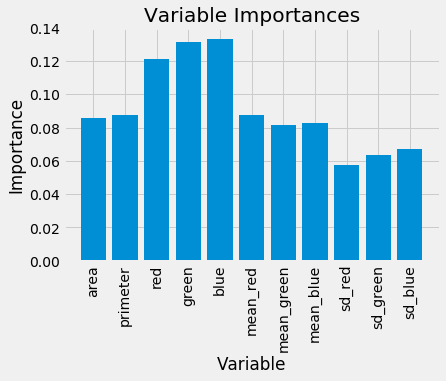

In [1075]:
importances = list(clf.feature_importances_)
feature_list = list(my_X.columns)

plt.style.use('fivethirtyeight')
x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation = 'vertical')

plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');